In [984]:
import os 
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy.table import Table
from astroML.filters import savitzky_golay, wiener_filter
%matplotlib inline

In [985]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing ZI tools for thermal analysis: 
import sputnikTools as s 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [986]:
## specifications for SOC-i from Boone Tate based on CAD model
def getInputParamsSOCi(SOCi="", case=0):   
    
    if (SOCi==""):
        SOCi = s.getInputParamsDefault()

    # area-weighted surface properties for the UW SOC-i satellite
    if case==0:
        alphaSOCi, epsSOCi = getSOCiSurfaceParamsDefault()
    if case==1:
        # change some properties to investigate passive thermal control
        alphaSOCi, epsSOCi = getSOCiSurfaceParamsModified()   
        
    # surface emissivity
    SOCi['alphaS'] = alphaSOCi  
    SOCi['epsT'] = epsSOCi      
    SOCi['alphaIR'] = SOCi['epsT']  # usual ansatz
    
    # thermal inertia
    # SOCi['mass'] = 2.6    # kg (from Boone Tate)
    # SOCi['C'] = 768.0     # J/kg/K, aluminum
    # new values, computed per component, for details see
    # https://docs.google.com/spreadsheets/d/1piuAet_vUGCSs8_of79RShUMD1PFj0KQeg_jvghkiSI/edit#gid=0
    SOCi['mass'] = 2.236   # kg  
    SOCi['C'] = 806.5     # J/kg/K 

    # battery charging/power dissipation
    SOCi['etaCell'] = 0.2 # fraction of energy for charging
    
    # effective areas for absorption
    SOCi['etaS'] = 0.21 
    SOCi['etaE'] = 0.36
    
    ## orbit
    SOCi['h'] = 550.0     # in km, orbit's altitude
    SOCi['PorbMin'] = 96  # orbital period in minutes
    SOCi['etaP'] = 0.375# fraction of orbit in eclipse: 36/96 
    
    return SOCi


def getSOCiSurfaceParamsDefault(verbose=False):
    ### from Boone Tate
    # Sides(2): 64% Solar Panel, 19% Aluminum Panels(outside), 17% aluminum frame rails
    # Sides(2): 57% Solar Panel, 26% aluminum panel(outside), 17% aluminum frame rails
    # Top: 60% Solar panel, 40% Aluminum frame
    # Bottom: 38% aluminum frame, 62% PCB
    ## from provided tables
    alphaSolPan = 0.92
    epsSolPan = 0.85 
    CSolPan = 324
    alphaAlPanOut = 0.87
    epsAlPanOut = 0.81 
    CAlPanOut = 801
    alphaAlFrameR = 0.86 
    epsAlFrameR = 0.86 
    CAlFrameR = 768
    alphaAlFrame = 0.08 
    epsAlFrame = 0.15 
    CAlFrame = 768
    alphaPCB = 0.81 
    epsPCB = 0.90 
    CPCB = 1544

    # total area in 0.1x0.1 units for Solar Panel
    SolPan = 4 * 0.64 + 4 * 0.57 + 1 * 0.6 
    AlPanOut = 4 * 0.19 + 4 * 0.26
    AlFrameR = 4 * 0.17 + 4 * 0.17 
    AlFrame = 1 * 0.4 + 1 * 0.38
    PCB = 1 * 0.62
    Atot = SolPan + AlPanOut + AlFrameR + AlFrame + PCB
    alphaSOCi = alphaSolPan*SolPan + alphaAlPanOut*AlPanOut + alphaAlFrameR*AlFrameR
    alphaSOCi = (alphaSOCi + alphaAlFrame*AlFrame + alphaPCB*PCB)/Atot
    epsSOCi = epsSolPan*SolPan + epsAlPanOut*AlPanOut + epsAlFrameR*AlFrameR
    epsSOCi = (epsSOCi + epsAlFrame*AlFrame + epsPCB*PCB)/Atot
    CSOCi = CSolPan*SolPan + CAlPanOut*AlPanOut + CAlFrameR*AlFrameR
    CSOCi = (CSOCi + CAlFrame*AlFrame + CPCB*PCB)/Atot
    if (verbose):
        print(SolPan, AlPanOut, AlFrameR, AlFrame, PCB)

    return alphaSOCi, epsSOCi 


def getSOCiSurfaceParamsModified(verbose=False):
    ### from Boone Tate
    # Sides(2): 64% Solar Panel, 19% Aluminum Panels(outside), 17% aluminum frame rails
    # Sides(2): 57% Solar Panel, 26% aluminum panel(outside), 17% aluminum frame rails
    # Top: 60% Solar panel, 40% Aluminum frame
    # Bottom: 38% aluminum frame, 62% PCB
    ## from provided tables
    alphaSolPan = 0.92
    epsSolPan = 0.85 
    CSolPan = 324
    alphaAlPanOut = 0.87
    epsAlPanOut = 0.81 
    CAlPanOut = 801
    alphaAlFrameR = 0.86 
    epsAlFrameR = 0.86 
    CAlFrameR = 768
    alphaAlFrame = 0.08 
    epsAlFrame = 0.15 
    CAlFrame = 768
    alphaPCB = 0.81 
    epsPCB = 0.90 
    CPCB = 1544
    
    ### MODIFICATIONS ### 
    # change Al frame properties from Al 5052 to Al 6061
    alphaAlFrame = 0.44 
    epsAlFrame = 0.14 
    # change PCB properties to copper
    alphaPCB = 0.30
    epsPCB = 0.03

    # total area in 0.1x0.1 units for Solar Panel
    SolPan = 4 * 0.64 + 4 * 0.57 + 1 * 0.6 
    AlPanOut = 4 * 0.19 + 4 * 0.26
    AlFrameR = 4 * 0.17 + 4 * 0.17 
    AlFrame = 1 * 0.4 + 1 * 0.38
    PCB = 1 * 0.62
    Atot = SolPan + AlPanOut + AlFrameR + AlFrame + PCB
    alphaSOCi = alphaSolPan*SolPan + alphaAlPanOut*AlPanOut + alphaAlFrameR*AlFrameR
    alphaSOCi = (alphaSOCi + alphaAlFrame*AlFrame + alphaPCB*PCB)/Atot
    epsSOCi = epsSolPan*SolPan + epsAlPanOut*AlPanOut + epsAlFrameR*AlFrameR
    epsSOCi = (epsSOCi + epsAlFrame*AlFrame + epsPCB*PCB)/Atot
    CSOCi = CSolPan*SolPan + CAlPanOut*AlPanOut + CAlFrameR*AlFrameR
    CSOCi = (CSOCi + CAlFrame*AlFrame + CPCB*PCB)/Atot
    if (verbose):
        print(SolPan, AlPanOut, AlFrameR, AlFrame, PCB)

    return alphaSOCi, epsSOCi 

In [989]:
print(getSOCiSurfaceParamsDefault())
print(getSOCiSurfaceParamsModified())

(0.8305000000000001, 0.7926600000000001)
(0.82696, 0.7379400000000002)


In [997]:
x = getInputParamsSOCi(SOCi="", case=0)
y = getInputParamsSOCi(SOCi="", case=1)
print(x['epsT'], y['epsT'])

0.7926600000000001 0.7379400000000002


In [979]:
# set default SOCi parameters 
SOCi = getInputParamsSOCi()
coldSOCi = s.getInputParamsCold(getInputParamsSOCi())  
hotSOCi = s.getInputParamsHot(getInputParamsSOCi())  
alphaSOCi = SOCi['alphaS']
epsSOCi = SOCi['epsT']

In [980]:
hotSOCi['Atot'] = 1.0
hotSOCi['etaS'] = 1.0
hotSOCi['etaE'] = 1.0
hotSOCi['etaCell'] = 0.0
Qsun2, Qref2, QIR2, Qdissip2 = s.getAllHeatQ(hotSOCi)
print(Qsun2, Qref2, QIR2, Qdissip2)
QinSun, QinEclipse = s.getQin(hotSOCi)
QinSun, QinEclipse

1180.9710000000002 21.01532155860408 174.6376194039525 0.0


(1376.6239409625568, 174.6376194039525)

In [981]:
coldSOCi['Atot'] = 1.0
coldSOCi['etaS'] = 1.0
coldSOCi['etaE'] = 1.0
coldSOCi['etaCell'] = 0.0
Qsun2, Qref2, QIR2, Qdissip2 = s.getAllHeatQ(coldSOCi)
print(Qsun2, Qref2, QIR2, Qdissip2)
QinSun, QinEclipse = s.getQin(coldSOCi)
QinSun, QinEclipse

1097.9210000000003 144.2049943263533 147.77029334180597 0.0


(1389.8962876681594, 147.77029334180597)

In [982]:
# set default SOCi parameters 
SOCi = getInputParamsSOCi()
coldSOCi = s.getInputParamsCold(getInputParamsSOCi())  
hotSOCi = s.getInputParamsHot(getInputParamsSOCi())  
alphaSOCi = SOCi['alphaS']
epsSOCi = SOCi['epsT']

In [343]:
## hot and cold cases for SOC-i (UW 2U CubeSat)
t1 = 'SOC-i hot case'  
t2 = 'SOC-i cold case'  

# default randomized orientations
hotSOCi['etaS'] = 0.21 
hotSOCi['etaE'] = 0.36
coldSOCi['etaS'] = 0.21 
coldSOCi['etaE'] = 0.36

verbose = True
time, Temps1 = s.doOneCase(t1, alphaSOCi, epsSOCi, hotSOCi, verbose)  
time, Temps2 = s.doOneCase(t2, alphaSOCi, epsSOCi, coldSOCi, verbose)  

name = 'SOCi-hotVScold'
s.TempsPlot(time, Temps2, t2, Temps1, t1, "", "", name)


SOC-i hot case Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 24.80039100000001 0.7565515761097468 6.28695429854229 5.111388515221951
Qsun= 31.843896874652046  Qeclipse= 11.398342813764241
Hot Eq. Temp: 290.12K = 16.97℃
Cold Eq. Temp: 224.41K = -48.74℃
adjusting Tmax= 290.12800008941895 to: Thot= 290.1237666671349
doOneCase: temp. range = 289.4641556946817 289.83364290046774
     in Celsius: range = 16.314155694681745 16.68364290046776

SOC-i cold case Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 23.056341000000007 5.191379795748719 5.319730560305015 3.530965099468591
Qsun= 31.44887229637259  Qeclipse= 8.850695659773606
Hot Eq. Temp: 289.22K = 16.07℃
Cold Eq. Temp: 210.65K = -62.50℃
doOneCase: temp. range = 258.98122604261715 274.44572157726554
     in Celsius: range = -14.168773957382825 1.2957215772655672


In [983]:
## hot and cold cases for SOC-i (UW 2U CubeSat)
t1 = 'SOC-i cold case, new CM'  
t2 = 'SOC-i cold case, old CM'  

# default randomized orientations
coldSOCiOLD = s.getInputParamsCold(getInputParamsSOCi())  
coldSOCiOLD['etaS'] = 0.21 
coldSOCiOLD['etaE'] = 0.36
coldSOCiOLD['mass'] = 2.6    # kg (from Boone Tate)
coldSOCiOLD['C'] = 768.0     # J/kg/K, aluminum

verbose = True
time, Temps1 = s.doOneCase(t1, alphaSOCi, epsSOCi, coldSOCi, verbose)  
time, Temps2 = s.doOneCase(t2, alphaSOCi, epsSOCi, coldSOCiOLD, verbose)  

name = 'SOCi-hotVScold-oldCM'
s.TempsPlot(time, Temps2, t2, Temps1, t1, "", "", name)


SOC-i cold case, new CM Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 23.056341000000007 5.191379795748719 5.319730560305015 3.530965099468591
Qsun= 31.44887229637259  Qeclipse= 8.850695659773606
Hot Eq. Temp: 289.22K = 16.07℃
Cold Eq. Temp: 210.65K = -62.50℃
doOneCase: temp. range = 258.311355201344 275.28496643856425
     in Celsius: range = -14.838644798655992 2.134966438564277

SOC-i cold case, old CM Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 23.056341000000007 5.191379795748719 5.319730560305015 3.530965099468591
Qsun= 31.44887229637259  Qeclipse= 8.850695659773606
Hot Eq. Temp: 289.22K = 16.07℃
Cold Eq. Temp: 210.65K = -62.50℃
doOneCase: temp. range = 258.98122604261715 274.44572157726554
     in Celsius: range = -14.168773957382825 1.2957215772655672


In [999]:
## hot and cold cases for SOC-i (UW 2U CubeSat)
t1 = 'SOC-i cold case'  
t2 = 'SOC-i, modified'  

# default randomized orientations
coldSOCi = s.getInputParamsCold(getInputParamsSOCi(SOCi="", case=0))  
coldSOCi['etaS'] = 0.21 
coldSOCi['etaE'] = 0.36
# modified
coldSOCiNEW = s.getInputParamsCold(getInputParamsSOCi(SOCi="", case=1))  
coldSOCiNEW['etaS'] = 0.21 
coldSOCiNEW['etaE'] = 0.36
aNEW = coldSOCiNEW['alphaS'] 
eNEW = coldSOCiNEW['epsT'] 

verbose = True
time, Temps1 = s.doOneCase(t1, alphaSOCi, epsSOCi, coldSOCi, verbose)  
time, Temps2 = s.doOneCase(t2, aNEW, eNEW, coldSOCiNEW, verbose)  

name = 'SOCi-hotVScold-newAlphaEps'
s.TempsPlot(time, Temps2, t2, Temps1, t1, "", "", name)


SOC-i cold case Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 23.056341000000007 5.191379795748719 5.319730560305015 3.530965099468591
Qsun= 31.44887229637259  Qeclipse= 8.850695659773606
Hot Eq. Temp: 289.22K = 16.07℃
Cold Eq. Temp: 210.65K = -62.50℃
doOneCase: temp. range = 258.311355201344 275.28496643856425
     in Celsius: range = -14.838644798655992 2.134966438564277

SOC-i, modified Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 22.958063520000003 5.169251578437519 4.952491572264884 3.51591438730469
Qsun= 30.970258038319592  Qeclipse= 8.468405959569573
Hot Eq. Temp: 293.31K = 20.16℃
Cold Eq. Temp: 212.10K = -61.05℃
doOneCase: temp. range = 262.00599775895904 278.86564102124163
     in Celsius: range = -11.144002241040937 5.715641021241652


In [344]:
## hot and cold cases for SOC-i (UW 2U CubeSat)
t1 = 'SOC-i hot case, extreme A'  
t2 = 'SOC-i cold case, extreme A'  

hotSOCi['etaS'] = 0.31 
hotSOCi['etaE'] = 0.38
coldSOCi['etaS'] = 0.10
coldSOCi['etaE'] = 0.34

verbose = True
time, Temps1 = s.doOneCase(t1, alphaSOCi, epsSOCi, hotSOCi, verbose)  
time, Temps2 = s.doOneCase(t2, alphaSOCi, epsSOCi, coldSOCi, verbose)  

name = 'SOCi-hotVScoldExtremeA'
s.TempsPlot(time, Temps2, t2, Temps1, t1, "", "", name)


SOC-i hot case, extreme A Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 36.61010100000001 0.798582219226955 6.636229537350196 7.481736643845394
Qsun= 44.04491275657716  Qeclipse= 14.11796618119559
Hot Eq. Temp: 314.63K = 41.48℃
Cold Eq. Temp: 236.74K = -36.41℃
doOneCase: temp. range = 313.7734606454903 314.559526678514
     in Celsius: range = 40.6234606454903 41.409526678514

SOC-i cold case, extreme A Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 10.979210000000004 4.902969807096012 5.024189973621403 1.985272475887002
Qsun= 19.71520629518522  Qeclipse= 7.009462449508405
Hot Eq. Temp: 257.35K = -15.80℃
Cold Eq. Temp: 198.72K = -74.43℃
doOneCase: temp. range = 235.51581095675334 244.2541254447327
     in Celsius: range = -37.634189043246636 -28.895874555267284


In [345]:
## extra heat on
t1 = 'SOC-i cold case'  
coldSOCi['etaS'] = 0.21 
coldSOCi['etaE'] = 0.36
Tcritical = 273.15
Pcritical = 5.0 
label = 'Extra 5 W when T$<$273 K'
name = 'SOCi-cold-heated5'

# analytic
timeA, TempsA = s.doOneCase(t1, alphaSOCi, epsSOCi, coldSOCi, verbose)   
# numerical test 
timeN, TempsN = s.getNumSolution(coldSOCi, 1.01*TempsA[0], Tcritical, Pcritical)
# plot
s.TempsPlotCompare(timeA, TempsA, timeN, TempsN, t1, label, name) 
print('Active control range:', np.min(TempsN-273.15), np.max(TempsN-273.15))



## extra heat on
t2 = 'SOC-i cold case'  
coldSOCi['etaS'] = 0.21 
coldSOCi['etaE'] = 0.36
Tcritical = 273.15
Pcritical = 2.0 
label = 'Extra 2 W when T$<$273 K'
name = 'SOCi-cold-heated2'

# analytic
timeA, TempsA = s.doOneCase(t2, alphaSOCi, epsSOCi, coldSOCi, verbose)   
# numerical test 
timeN, TempsN = s.getNumSolution(coldSOCi, 1.01*TempsA[0], Tcritical, Pcritical)
# plot
s.TempsPlotCompare(timeA, TempsA, timeN, TempsN, t2, label, name) 
print('Active control range:', np.min(TempsN-273.15), np.max(TempsN-273.15))


## extra heat on
t3 = 'SOC-i cold case'  
coldSOCi['etaS'] = 0.21 
coldSOCi['etaE'] = 0.36
Tcritical = 273.15
Pcritical = 10.0 
label = 'Extra 10 W when T$<$273 K'
name = 'SOCi-cold-heated10'

# analytic
timeA, TempsA = s.doOneCase(t3, alphaSOCi, epsSOCi, coldSOCi, verbose)   
# numerical test 
timeN, TempsN = s.getNumSolution(coldSOCi, 1.01*TempsA[0], Tcritical, Pcritical)
# plot
s.TempsPlotCompare(timeA, TempsA, timeN, TempsN, t3, label, name) 
print('Active control range:', np.min(TempsN-273.15), np.max(TempsN-273.15))



t4 = 'SOC-i cold case, extreme A'  
coldSOCi['etaS'] = 0.10
coldSOCi['etaE'] = 0.34
Tcritical = 273.15
Pcritical = 5.0 
label = 'Extra 5 W when T$<$273 K'
name = 'SOCi-cold-extrA-heated5'

# analytic
timeA, TempsA = s.doOneCase(t4, alphaSOCi, epsSOCi, coldSOCi, verbose)   
# numerical test 
timeN, TempsN = s.getNumSolution(coldSOCi, 1.01*TempsA[0], Tcritical, Pcritical)
# plot
s.TempsPlotCompare(timeA, TempsA, timeN, TempsN, t4, label, name) 
print('Active control range:', np.min(TempsN-273.15), np.max(TempsN-273.15))


SOC-i cold case Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 23.056341000000007 5.191379795748719 5.319730560305015 3.530965099468591
Qsun= 31.44887229637259  Qeclipse= 8.850695659773606
Hot Eq. Temp: 289.22K = 16.07℃
Cold Eq. Temp: 210.65K = -62.50℃
doOneCase: temp. range = 258.98122604261715 274.44572157726554
     in Celsius: range = -14.168773957382825 1.2957215772655672
Active control range: -7.029643321464789 6.401408390095526

SOC-i cold case Sphere, Temperature Extremes
-------------------------------------------------------
Q (sun, alb, IR, diss): 23.056341000000007 5.191379795748719 5.319730560305015 3.530965099468591
Qsun= 31.44887229637259  Qeclipse= 8.850695659773606
Hot Eq. Temp: 289.22K = 16.07℃
Cold Eq. Temp: 210.65K = -62.50℃
doOneCase: temp. range = 258.98122604261715 274.44572157726554
     in Celsius: range = -14.168773957382825 1.2957215772655672
Active control range: -10.073203396790575 4.47740863232

In [346]:
coldSOCi

{'Fsun': 1322,
 'FIR': 220,
 'rhoE': 0.25,
 'h': 550.0,
 'PorbMin': 96,
 'etaP': 0.375,
 'falb': 0.62,
 'fE': 0.8473786384498566,
 'Atot': 0.1,
 'etaS': 0.1,
 'etaE': 0.34,
 'alphaS': 0.8305000000000001,
 'epsT': 0.7926600000000001,
 'alphaIR': 0.7926600000000001,
 'mass': 2.6,
 'C': 768.0,
 'etaCell': 0.2}

In [347]:
SOCi

{'Fsun': 1372,
 'FIR': 240,
 'rhoE': 0.3,
 'h': 550.0,
 'PorbMin': 96,
 'etaP': 0.375,
 'falb': 0.62,
 'fE': 0.8473786384498566,
 'Atot': 0.1,
 'etaS': 0.21,
 'etaE': 0.36,
 'alphaS': 0.8305000000000001,
 'epsT': 0.7926600000000001,
 'alphaIR': 0.7926600000000001,
 'mass': 2.6,
 'C': 768.0,
 'etaCell': 0.2}

In [348]:
hotSOCi

{'Fsun': 1422,
 'FIR': 260,
 'rhoE': 0.35,
 'h': 550.0,
 'PorbMin': 96,
 'etaP': 0.0,
 'falb': 0.06,
 'fE': 0.8473786384498566,
 'Atot': 0.1,
 'etaS': 0.31,
 'etaE': 0.38,
 'alphaS': 0.8305000000000001,
 'epsT': 0.7926600000000001,
 'alphaIR': 0.7926600000000001,
 'mass': 2.6,
 'C': 768.0,
 'etaCell': 0.2}

In [349]:
def plotQs(alpha, Qsun, Qcell):
    
    fig = plt.figure(figsize=(9, 4))
    fig.subplots_adjust(bottom=0.09, left=0.11, right=0.96, top = 0.98, wspace=0.30, hspace=0.3)

    ax = fig.add_subplot(1,2,1)
    ax.plot(alpha, Qsun['Xp']+Qsun['Xm'], '-g') 
    ax.plot(alpha, Qsun['Yp']+Qsun['Ym'], '--r') 
    ax.plot(alpha, Qsun['Zp']+Qsun['Zm'], '-.b') 
    #ax.plot(alpha, eta, '--k') 
    #ax.plot(alpha, fac, '--y') 
    ax.set_xlabel(r'$\alpha$ (orbit angle)')
    ax.set_ylabel(r'Q for non-solar-cell areas (W)')
    ax.set_ylim(-0.05,15)

    ax = fig.add_subplot(1,2,2)
    ax.plot(alpha, Qcell['Xp']+Qcell['Xm'], '-g') 
    ax.plot(alpha, Qcell['Yp']+Qcell['Xm'], '--r') 
    ax.plot(alpha, Qcell['Zp']+Qcell['Xm'], '-.b') 
    #ax.plot(alpha, eta, '--k') 
    #ax.plot(alpha, fac, '--y') 
    ax.set_xlabel(r'$\alpha$ (orbit angle)')
    ax.set_ylabel(r'Q for solar cells (W)')
    ax.set_ylim(-0.05,15)
    plt.show()    

    
def plotQsAllSides(alpha, Qheat, Qcharge, ymin=0, ymax=40):
    
    fig = plt.figure(figsize=(9, 4))
    fig.subplots_adjust(bottom=0.09, left=0.11, right=0.96, top = 0.98, wspace=0.30, hspace=0.3)

    ax = fig.add_subplot(1,2,1)
    ax.plot(alpha, Qheat, '-r') 
    ax.plot(alpha, Qcharge, '--b') 
    ax.set_xlabel(r'$\alpha$ (orbit angle)')
    ax.set_ylabel(r'Qheat and Pcharge (W)')
    ax.set_ylim(ymin, ymax)
    plt.show()  

In [1016]:
# set default SOCi parameters 
c = 1
SOCi = getInputParamsSOCi(SOCi="", case=c)
coldSOCi = s.getInputParamsCold(getInputParamsSOCi(SOCi="", case=c))  
hotSOCi = s.getInputParamsHot(getInputParamsSOCi(SOCi="", case=c))  

In [1017]:
cold = True
if cold:
    # beta=0 orbit
    alphaOrbit, fEcl, fAlb, areaS, areaE, etaS, etaE = s.getAreasForOrbitImagingMode(50, beta0=True)
    case = coldSOCi
else:
    # beta=90 orbit
    alphaOrbit, fEcl, fAlb, areaS, areaE, etaS, etaE = s.getAreasForOrbitImagingMode(50, beta0=False)
    case = hotSOCi
realAreaFac, realAlpha, realEps = s.getSOCiRealAreas(SolarCells=False)
realAreaFacCells, realAlphaCells, realEpsCells = s.getSOCiRealAreas(SolarCells=True)

assuming beta=0 sun-synchronous orbit


In [1018]:
case = coldSOCi

In [1019]:
QsunNotCell = s.getQsunOrbit(case, areaS, realAreaFac, realAlpha, fEcl)
QsunSolCell = s.getQsunOrbit(case, areaS, realAreaFacCells, realAlphaCells, fEcl)
QrefNotCell = s.getQrefOrbit(case, areaE, realAreaFac, realAlpha, fEcl, fAlb)
QrefSolCell = s.getQrefOrbit(case, areaE, realAreaFacCells, realAlphaCells, fEcl, fAlb)
QIR = s.getQIROrbit(coldSOCi, areaE, realAreaFac, realEps)
etaCell = case['etaCell']  
print('etaCell=', etaCell)
QheatSol, QheatRef, QheatIR, Qcharge = s.sumQsForAllSides(QsunNotCell, QsunSolCell, QrefNotCell, QrefSolCell, QIR, etaCell)
QheatTotal = QheatSol + QheatRef + QheatIR

etaCell= 0.2


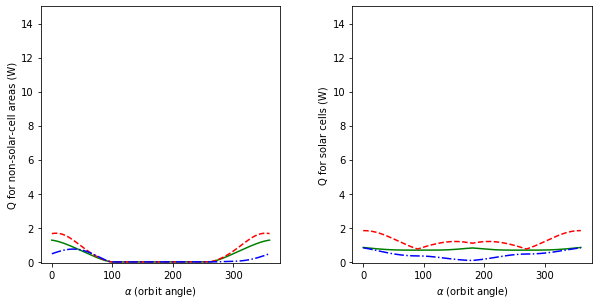

In [1020]:
# plotQs(alphaOrbit, QsunNotCell, QsunSolCell)
# plotQs(alphaOrbit, QrefNotCell, QrefSolCell)
plotQs(alphaOrbit, QrefNotCell, QIR) 

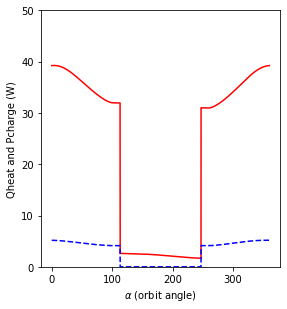

In [1021]:
plotQsAllSides(alphaOrbit, QheatTotal, Qcharge, 0, 50)

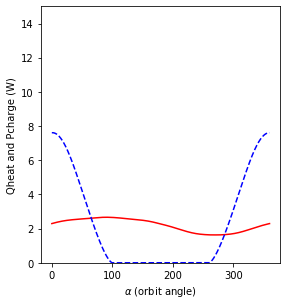

In [1022]:
plotQsAllSides(alphaOrbit, QheatIR, QheatRef, 0, 15)

In [1023]:
time0, Temp0, Q0 = s.getTsolution(alphaOrbit, QheatTotal, case, 273, 0, Niter=25)

after 25 iterations, T tolerance =  -1.2782465432792378e-06 259.10400370190456 283.1662494393263


In [1024]:
time5, Temp5, Q5 = s.getTsolution(alphaOrbit, QheatTotal, case, 273, 3, Niter=25)

after 25 iterations, T tolerance =  -1.8039040469375323e-05 262.80010957290386 286.17452033817887


In [1025]:
#title = 'beta=0 orbit, imaging mode'
title = 'beta=0 orbit, sun seeker mode' 
#title = 'beta=90 orbit, imaging mode'
#outfile = 'B0imaging'
# outfile = 'B0sunSeeker'
outfile = 'B0sunSeekerTest2'
#outfile = 'B90imaging'
L1= '$P_{battery}$'
L2 = '$P_{heat}$ = 0 W'
L3 = '$P_{heat}$ = 3 W'
#L3 = '$P_{heat}$ = 6 W'
s.TempsPowerOrbit(time0, Qcharge, L1, time0, Q0, L2, time5, Q5, L3, outfile, title) 

made figure figures/PowerTimeOrbitB0sunSeekerTest2.png


In [1026]:
Temp5x = Temp5-0.0
s.TempsPlotOrbit(time0, Temp0, L2, time5, Temp5x, L3, "", "", "", outfile, title) 

made figure figures/TempTimeOrbitB0sunSeekerTest2.png


In [1027]:
spentOnHeat = (time0[-1]/60) * (np.mean(Q5)-np.mean(Q0))
batteryCharge = (time0[-1]/60) * (np.mean(Qcharge))
print(batteryCharge, spentOnHeat)

4.6412301946706185 1.9720000000000084


In [957]:
## beta       mode      battery   heater power   heater consumed 
#                      Whr/orb       W             Whr/orb 
#   0      imaging      4.04        2.0             3.19   
#   0     sun seaker    4.68        5.0             3.57   old thetaE, phiE
#   0     sun seaker    4.64        5.0             3.74   deltaTmean = 6.6 C  *plots*  
#   0     sun seaker    4.64        5.0             2.70   5W at 268K vs. 273K, Tmean = 4.8 C  
#   0     sun seaker    4.64        2.0             1.91   test plots, dTmean = 3.4 C (1W: 1.9C, 1.1 Whr) 
#   0     sun seaker    5.02        2.0             1.41   beta=45 eclipse, dTmean = 2.4 C 
#  90  both, cold case  6.68        0.0             0.00   no plots
#  90  both, hot case   7.21        0.0             0.00  
# new
#   0     sun seaker    4.64        0.0             0.00   only 1.34 Whr really charged above 0 C
#   0     sun seaker    4.64        3.0             2.62   deltaTmean = 4.7C  *test plots* 2.45 Whr charged
#   0     sun seaker    4.64        6.0             4.18   dTmean = 7.4C  *plots* only 3.1Whr really charged 
#  ** different material properties **
#   0     sun seaker    4.64        0.0  NEW a/eps  0.00   2.3Whr really charged             
#   0     sun seaker    4.64        3.0  NEW a/eps  1.97   dTmean = 3.6C   3.1Whr really charged             
# hot case
#   0     sun seaker    5.20        0.0             0.00   only 2.99 Whr really charged above 0 C HOTCASE.png
#   0     sun seaker    5.20        3.0             1.74   deltaTmean = 2.9C,  3.68 Whr charged
#   0     sun seaker    5.20        6.0             2.80   deltaTmean = 4.6C,  4.15 Whr charged
# NB
# 4 batteries can store 20.8 Whr  
# cells generate 6 W when not in eclipse, about 6 Whr per orbit

In [1028]:
print(np.mean(Temp5-Temp0))

3.609227705983728


In [1029]:
print((time0[-1]/60) * (np.mean(Qcharge)))

4.6412301946706185


In [1030]:
print((time0[-1]/60) * (np.mean(Qcharge[Temp0>273]))*time0[Temp0>273].size/time0.size)

2.310878757758953


In [1031]:
print((time5[-1]/60) * (np.mean(Qcharge[Temp5>273]))*time0[Temp5>273].size/time0.size)

3.0895156133859474


In [1032]:
print('etaS:', np.mean(etaS), np.std(etaS))
print('etaE:', np.mean(etaE), np.std(etaE))

etaS: 0.2818088518920079 1.1102230246251565e-16
etaE: 0.35296202278977173 0.009246124853437294
